In [1]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [2]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif "martyna" in os.environ.get('USER'):



In [2]:

DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [3]:
foof = pd.read_csv(DATA_DIR+"source_intercept_slope.csv")
#foof = foof.drop('Unnamed: 0', 1)
foof

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,IDs
0,0.160123,1.362617,-0.002037,1.427172,0.810964,1.391837,0.745124,1.378194,0.527491,1.433532,...,1.519565,1.004265,1.450747,0.956578,1.456952,0.611944,1.503932,0.282555,1.441946,NDARAA075AMK
1,0.988915,1.330636,1.151667,1.546990,1.479442,1.608810,1.342563,1.559859,0.460923,1.434832,...,1.461904,1.449481,1.480738,0.889122,1.282076,0.950479,1.138697,1.372408,1.505823,NDARAA112DMH
2,1.455004,1.515717,0.988018,1.367703,2.029333,1.763131,2.086803,1.763987,1.320758,1.585413,...,1.502295,1.596192,1.448922,1.180667,1.199036,1.658822,1.619147,1.182087,1.395998,NDARAA117NEJ
3,0.796931,1.547997,0.016022,0.956344,0.638462,1.222323,0.698921,1.395078,-0.130122,1.156477,...,0.998001,0.079507,1.285272,0.471817,1.175649,0.617125,1.418717,0.401675,1.222953,NDARAA947ZG5
4,-0.627481,1.123518,-0.255195,1.273727,0.197328,1.344738,0.282533,1.387126,-0.808075,1.077384,...,1.363285,0.049249,1.207528,-0.118998,1.296786,-0.253839,1.176320,-0.033039,1.318181,NDARAA948VFH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,-0.124896,1.111637,0.025096,1.109243,0.393830,0.864464,0.422308,0.871363,-0.311337,0.979262,...,1.104898,0.215057,0.976700,0.769451,1.101020,-0.013650,1.085802,0.159527,1.034021,NDARRY126FA5
1408,0.259345,1.268732,0.532802,1.492400,0.722490,1.482126,0.730926,1.432505,-0.205835,1.230099,...,1.508386,0.529724,1.352627,1.061175,1.606489,0.540497,1.275614,0.835786,1.468853,NDARRY215CXQ
1409,0.396271,1.361393,0.176390,1.363488,0.753262,1.453320,0.707356,1.481902,-0.070967,1.338482,...,1.348029,0.901967,1.433662,0.392497,1.112497,0.585191,1.396128,0.307516,1.337915,NDARRY268AF2
1410,0.300712,1.325074,0.534767,1.416291,0.846201,1.590482,0.853024,1.632593,0.317269,1.416499,...,1.399847,0.863988,1.219525,1.119859,1.336477,0.667894,1.395374,0.618072,1.330237,NDARRY280KNW


In [4]:
data = mat73.loadmat(DATA_DIR+'x_source_new.mat')  
df2 = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))

# sparsing
df2 = np.array(df2).reshape(data['x'].shape) 
df2_sparsed = np.concatenate([np.expand_dims(df2[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
df2 = pd.DataFrame(df2_sparsed.reshape((df2_sparsed.shape[0], -1)))

#scaling
norm = MinMaxScaler().fit(df2)
df2 = norm.transform(df2)
df2 = pd.DataFrame(df2.reshape((df2.shape[0], -1)))

df2['IDs'] = foof['IDs']
df2

,0,1,2,3,4,5,6,7,8,9,...,2643,2644,2645,2646,2647,2648,2649,2650,2651,IDs
0,5.101913e-11,1.992207e-08,2.402816e-06,1.218602e-04,3.864207e-03,0.040095,0.179954,4.270175e-01,4.634880e-01,3.890722e-01,...,3.843416e-03,2.106884e-04,5.118096e-06,4.670563e-08,1.832631e-10,3.079021e-13,1.701302e-16,0.000000e+00,0.000000e+00,NDARAA075AMK
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,6.776939e-17,5.105700e-16,5.725257e-15,...,2.088142e-01,2.313505e-01,4.140847e-01,2.058921e-01,3.437418e-01,1.930270e-01,2.860178e-01,4.766788e-02,7.230240e-04,NDARAA112DMH
2,2.661419e-02,1.264720e-01,8.284766e-06,2.918035e-12,3.280463e-09,0.000007,0.038736,1.984120e-01,2.976885e-01,4.438104e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NDARAA117NEJ
3,2.380404e-02,4.203522e-01,3.468028e-01,3.200351e-01,4.774229e-01,0.074612,0.079222,1.015326e-01,9.357454e-02,1.306764e-01,...,1.911892e-01,6.062096e-02,4.113846e-01,7.161245e-01,3.323713e-01,5.250955e-02,1.845979e-01,4.270583e-01,1.610893e-01,NDARAA947ZG5
4,2.394631e-01,4.350986e-01,3.745264e-01,2.070651e-01,1.087368e-01,0.030269,0.095985,2.162397e-01,1.855508e-01,1.166599e-01,...,6.742616e-02,7.341512e-02,8.137233e-02,7.837132e-02,7.548040e-02,7.270647e-02,1.187193e-01,7.464320e-02,6.494024e-02,NDARAA948VFH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,3.739917e-03,1.621763e-01,1.145210e-01,1.717832e-03,2.876346e-03,0.036229,0.203065,2.488511e-01,1.714610e-01,8.331924e-02,...,1.686810e-03,1.423780e-04,1.267766e-05,1.576811e-06,2.304640e-07,3.126707e-08,3.797884e-09,4.119393e-10,3.989325e-11,NaN
2038,2.134005e-06,4.229760e-04,1.248026e-02,7.758914e-02,1.714416e-01,0.180892,0.169312,1.428294e-01,2.635778e-01,3.428152e-01,...,2.357898e-07,3.632691e-08,5.206799e-09,5.926503e-10,6.164682e-11,5.860062e-12,5.090295e-13,4.043299e-14,2.933030e-15,NaN
2039,5.561633e-16,1.265773e-12,8.057262e-10,1.905719e-07,2.488557e-05,0.000939,0.013563,9.140757e-02,1.911413e-01,2.630192e-01,...,7.135652e-02,9.507114e-02,1.348492e-01,1.594672e-01,1.807321e-01,1.963087e-01,2.043546e-01,2.038778e-01,1.949377e-01,NaN
2040,1.186254e-07,1.126116e-05,3.801973e-04,6.209405e-03,7.283916e-02,0.320383,0.696183,9.051547e-01,5.121514e-01,2.078802e-01,...,1.125051e-03,3.257921e-04,8.646941e-05,1.795490e-05,3.356598e-06,5.649386e-07,8.560071e-08,1.167659e-08,1.433856e-09,NaN


In [5]:
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
print('Before:'+str(beh.shape))

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# removing patients with incomplete eval
initial_size = beh.shape[0]
beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
beh = beh.reset_index(drop=True)
new_size = beh.shape[0]

print('After:'+str(beh.shape))
print('Removing', initial_size - new_size,
      'patients as their evaluations was incomplete.')

Before:(3076, 177)
After:(2939, 177)
Removing 137 patients as their evaluations was incomplete.


In [6]:
no_diagnosis_given = 'No Diagnosis Given'

diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
diagnoses_to_ids

{'Attention-Deficit/Hyperactivity Disorder': 0,
 'Anxiety Disorders': 1,
 'Specific Learning Disorder': 2,
 'Autism Spectrum Disorder': 3,
 'Disruptive': 4,
 'Communication Disorder': 5,
 'Depressive Disorders': 6,
 'No Diagnosis Given': 7,
 'Other Disorders': 8}

In [7]:
def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(beh.shape[0]):
    i = 0
    disorder = get_disorder(beh, k, i)
    disorders_patient = []
    while not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        else:
            if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids['Other Disorders'])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(beh, k, i)

        
    order_of_disorders.append(disorders_patient)

In [8]:
other_disorders = []
no_diagnosis_given = []
for i in order_of_disorders:
    if 7 in i:
        no_diagnosis_given.append(1)
        i.remove(7)
    else:
        no_diagnosis_given.append(0)
    if 8 in i:
        other_disorders.append(1)
        i.remove(8)
    else:
        other_disorders.append(0)

In [9]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

classes = np.zeros((len(most_common_disorders),
                    beh.shape[0]), dtype=np.int32)

df_disorders = beh[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

behaviour_data_columns = beh.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = beh.drop(columns=columns_to_drop)

for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [10]:
common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders']

labels=behaviour_data[["IDs"]+list(common_disorders)]
labels["Other Disorders"] = other_disorders
labels

/tmp/ipykernel_1530190/226828375.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Other Disorders"] = other_disorders


,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,NDARAA075AMK,0,0,0,0,0,0,0,0
1,NDARAA112DMH,1,0,0,0,1,0,0,1
2,NDARAA117NEJ,1,0,0,0,1,0,0,1
3,NDARAA306NT2,1,1,1,0,0,1,0,1
4,NDARAA504CRN,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
2934,NDARZZ007YMP,0,0,0,1,0,0,0,1
2935,NDARZZ740MLM,1,0,0,0,0,0,0,0
2936,NDARZZ810LVF,0,0,0,1,0,1,0,1
2937,NDARZZ830JM7,0,0,0,1,0,0,0,1


In [11]:
df = pd.merge(df2, foof, on='IDs', how='inner')
df = pd.merge(df2, labels, on='IDs', how='inner')
df

,0,1,2,3,4,5,6,7,8,9,...,2651,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,5.101913e-11,1.992207e-08,2.402816e-06,1.218602e-04,3.864207e-03,4.009528e-02,1.799539e-01,4.270175e-01,4.634880e-01,3.890722e-01,...,0.000000,NDARAA075AMK,0,0,0,0,0,0,0,0
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.776939e-17,5.105700e-16,5.725257e-15,...,0.000723,NDARAA112DMH,1,0,0,0,1,0,0,1
2,2.661419e-02,1.264720e-01,8.284766e-06,2.918035e-12,3.280463e-09,6.808455e-06,3.873552e-02,1.984120e-01,2.976885e-01,4.438104e-01,...,0.000000,NDARAA117NEJ,1,0,0,0,1,0,0,1
3,2.380404e-02,4.203522e-01,3.468028e-01,3.200351e-01,4.774229e-01,7.461242e-02,7.922153e-02,1.015326e-01,9.357454e-02,1.306764e-01,...,0.161089,NDARAA947ZG5,1,0,1,1,0,0,0,1
4,2.394631e-01,4.350986e-01,3.745264e-01,2.070651e-01,1.087368e-01,3.026856e-02,9.598491e-02,2.162397e-01,1.855508e-01,1.166599e-01,...,0.064940,NDARAA948VFH,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,5.342343e-09,3.195851e-08,2.003322e-06,1.136175e-04,3.927355e-03,4.250591e-02,1.905152e-01,4.299257e-01,3.231411e-01,1.705013e-01,...,0.235636,NDARRY112RAK,1,1,0,0,0,0,0,1
1334,1.301025e-15,8.855690e-15,4.035589e-14,1.504955e-06,1.062141e-01,5.335448e-02,4.013857e-02,7.735320e-02,1.213426e-01,1.911046e-01,...,0.141748,NDARRY126FA5,0,1,0,0,0,0,1,0
1335,1.313673e-12,6.529546e-12,2.192466e-11,6.742710e-11,2.809208e-10,8.245398e-10,2.238683e-09,6.787882e-09,1.513961e-08,5.234011e-08,...,0.000000,NDARRY215CXQ,1,0,0,0,0,0,0,0
1336,2.610322e-05,3.199561e-03,5.956507e-02,2.386200e-01,3.216022e-01,2.334303e-01,5.749975e-01,5.311708e-01,3.123856e-01,6.358041e-02,...,0.241064,NDARRY268AF2,1,0,0,0,0,0,0,0


### Data Split

In [12]:
disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders', 'Other Disorders']
x = df[df.columns.difference(['IDs']+disorders_list)]
y = df[disorders_list]

# summarize dataset shape
print(x.shape, y.shape)

(1338, 2652) (1338, 8)


In [13]:
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

In [14]:
train_labels = np. array(train_labels) 
test_labels = np. array(test_labels) 

In [15]:
print(train_features.shape, test_features.shape)

(1003, 2652) (335, 2652)


## FEATURE EXTRACTION WITH PCA

In [16]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1003, 2652) (335, 2652)


In [17]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1003, 362) (335, 362)


In [18]:
train_labels.sum(axis=0)

array([601, 340, 236, 150, 157, 154,  97, 407])

In [19]:
test_labels.sum(axis=0)

array([213, 102,  75,  51,  50,  55,  37, 133])

## FEATURE EXTRACTION WITH AUTOENCODER

In [20]:
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
# from tensorflow.keras.utils import plot_model, to_categorical

# n_inputs = train_features.shape[1]

# visible = Input(shape=(n_inputs,))
# e = Dense(n_inputs*2)(visible)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# e = Dense(n_inputs)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# n_bottleneck = round(float(n_inputs) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)

# d = Dense(n_inputs)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# d = Dense(n_inputs*2)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# output = Dense(8, activation='linear')(d)

# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
# encoder = Model(inputs=visible, outputs=bottleneck)

# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# encoder.save('autoencoder.h5')

In [21]:
# # encode the data
# encoder= load_model('autoencoder.h5', compile=False)

# train_features = encoder.predict(train_features)
# test_features = encoder.predict(test_features)

### Metrics

In [22]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["micro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["micro"]

In [23]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy, hamming, brier_score, report

## Models

In [24]:
model_names = []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    model_names.append(model_name)

### Random Baseline

In [25]:
%%capture

import sys, os
    
n = 1000

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    
record_values(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg), 'Shuffling Baseline')


#### Dummy classifiers

In [26]:
%%capture

from sklearn.dummy import DummyClassifier

strategies = ['stratified', 'most_frequent', 'uniform']
for strategy_ in strategies:
    dummy_clf = DummyClassifier(strategy=strategy_)
    dummy_clf.fit(train_features, train_labels)
    predicted_labels = np.asarray(dummy_clf.predict_proba(test_features))[:, :, 1].T
    print('Dummy Classifier-' + strategy_)
    evaluate(test_labels, predicted_labels)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
    pr = plot_pr_curve(test_labels, predicted_labels)
    roc = plot_roc_curve(test_labels, predicted_labels)
    record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Dummy Classifier-' + strategy_)

### Multi Output Classifier

LogisticRegression():
Accuracy: 0.08059701492537313
Hamming Loss: 0.28059701492537314
Brier Score: 1.6433774398110255
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.69      0.65       213
           1       0.38      0.33      0.35       102
           2       0.14      0.08      0.10        75
           3       0.23      0.10      0.14        51
           4       0.18      0.06      0.09        50
           5       0.25      0.07      0.11        55
           6       0.33      0.16      0.22        37
           7       0.48      0.40      0.43       133

   micro avg       0.47      0.36      0.41       716
   macro avg       0.33      0.24      0.26       716
weighted avg       0.41      0.36      0.37       716
 samples avg       0.55      0.44      0.34       716

Confusion matrix:
 [[[ 35  87]
  [ 67 146]]

 [[177  56]
  [ 68  34]]

 [[223  37]
  [ 69   6]]

 [[267  17]
  [ 46   5]]

 [[271  14]
  [ 47   3]]

 [[2

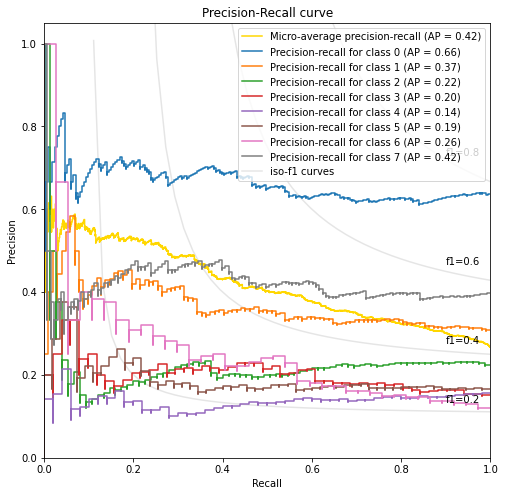

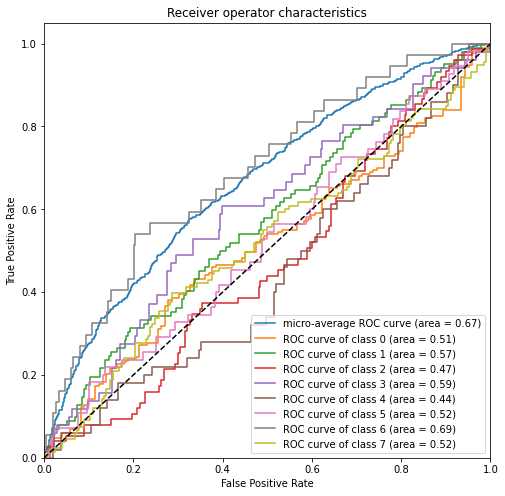

RandomForestClassifier(random_state=1):
Accuracy: 0.1373134328358209
Hamming Loss: 0.23619402985074628
Brier Score: 1.3995325373134329
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.94      0.76       213
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        75
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        50
           5       1.00      0.04      0.07        55
           6       0.00      0.00      0.00        37
           7       0.55      0.09      0.15       133

   micro avg       0.62      0.30      0.40       716
   macro avg       0.27      0.13      0.12       716
weighted avg       0.37      0.30      0.26       716
 samples avg       0.65      0.42      0.39       716

Confusion matrix:
 [[[  9 113]
  [ 12 201]]

 [[230   3]
  [102   0]]

 [[258   2]
  [ 75   0]]

 [[283   1]
  [ 51   0]]

 [[283   2]
 

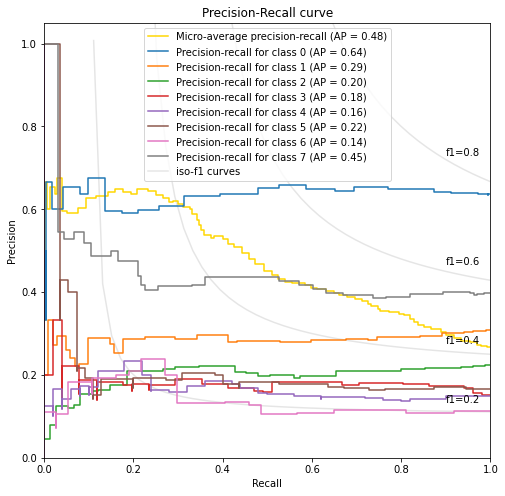

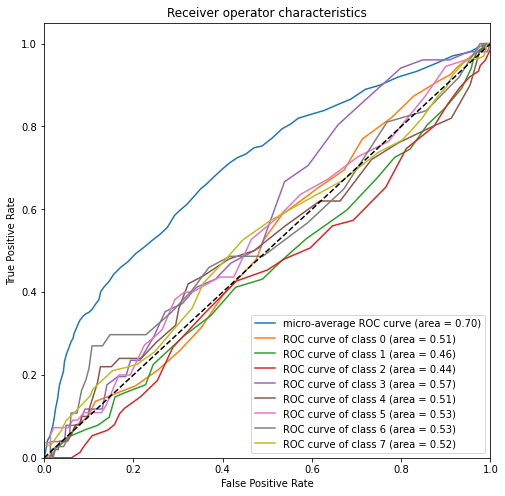

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
forest = RandomForestClassifier(random_state=1)
lg = LogisticRegression()
models = [lg, forest]

for model in models:

    multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_output_model.fit(train_features, train_labels)
    predicted_labels = np.asarray(multi_output_model.predict_proba(test_features))[:, :, 1].T
    print(str(model)+':')
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels)
    pr = plot_pr_curve(test_labels, predicted_labels)
    roc = plot_roc_curve(test_labels, predicted_labels)
    record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MOC: '+str(model))

## MLP simple

2021-12-07 14:17:52.446970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-07 14:17:52.453268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 14:17:52.453568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-12-07 14:17:52.453712: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-07 14:17:52.454781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-07 14:17:52.455982: I tensorflow/stream_executor/platform/default/d

Epoch 1/100
 1/32 [..............................] - ETA: 0s - loss: 0.8023

2021-12-07 14:17:53.152950: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


32/32 [==============================] - 0s 1ms/step - loss: 0.7167
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5956
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5340
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4982
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4737
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4551
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4389
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4235
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4091
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.3949
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.3813
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 0.3673
Epoch 13/100
32/32 [=============================

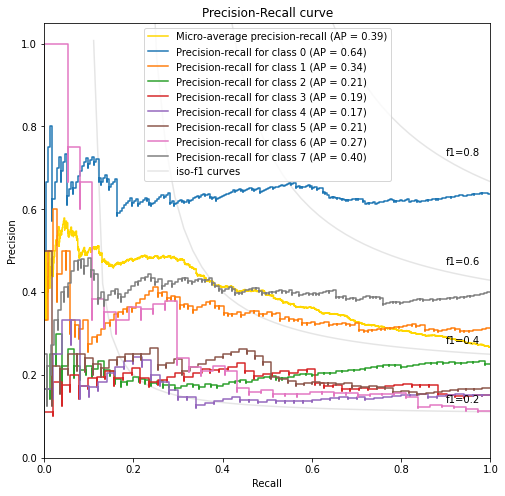

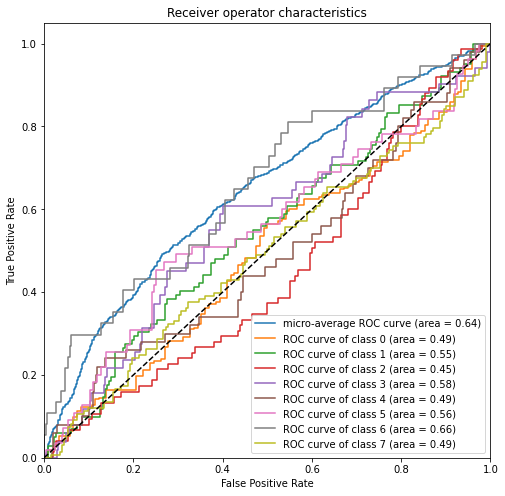

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_mlp)

pr = plot_pr_curve(test_labels, predicted_labels_mlp)
roc = plot_roc_curve(test_labels, predicted_labels_mlp)
record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP-1L')

## MLP complex

Epoch 1/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7241
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6131
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5359
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.5077
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4939
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4821
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4714
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4602
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4490
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4363
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4223
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4066
Epoch 13/100
32/32 [=================

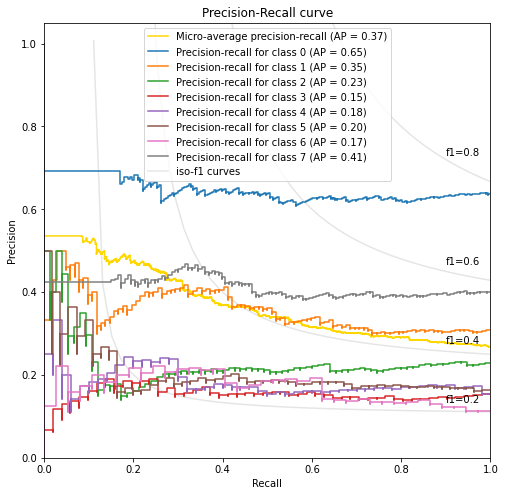

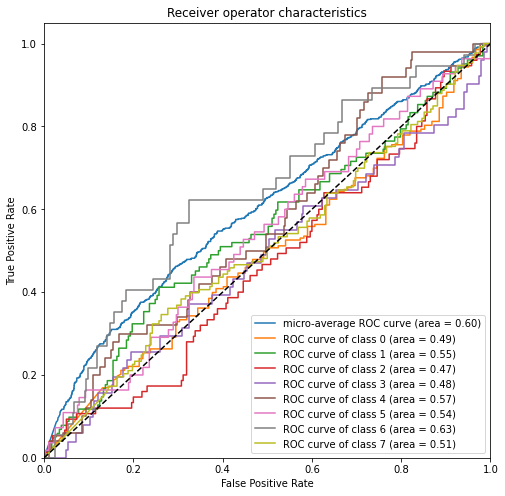

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_mlp)

pr = plot_pr_curve(test_labels, predicted_labels_mlp)
roc = plot_roc_curve(test_labels, predicted_labels_mlp)
record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MLP')

### Binary Relevance
ignores the possible correlations between class labels

In [30]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(train_features, train_labels)

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])

In [31]:
predicted_labels_br = classifier.predict_proba(test_features)
accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_br.toarray())

Accuracy: 0.029850746268656716
Hamming Loss: 0.3559701492537313
Brier Score: 2.363282799680853
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.32      0.45       213
           1       0.33      0.77      0.47       102
           2       0.22      0.51      0.31        75
           3       0.15      0.10      0.12        51
           4       0.17      0.08      0.11        50
           5       0.30      0.05      0.09        55
           6       0.18      0.46      0.25        37
           7       0.49      0.23      0.32       133

   micro avg       0.34      0.34      0.34       716
   macro avg       0.32      0.32      0.26       716
weighted avg       0.43      0.34      0.33       716
 samples avg       0.38      0.42      0.30       716

Confusion matrix:
 [[[ 96  26]
  [144  69]]

 [[ 76 157]
  [ 23  79]]

 [[126 134]
  [ 37  38]]

 [[256  28]
  [ 46   5]]

 [[265  20]
  [ 46   4]]

 [[273   7]
  [ 52   3]]

 

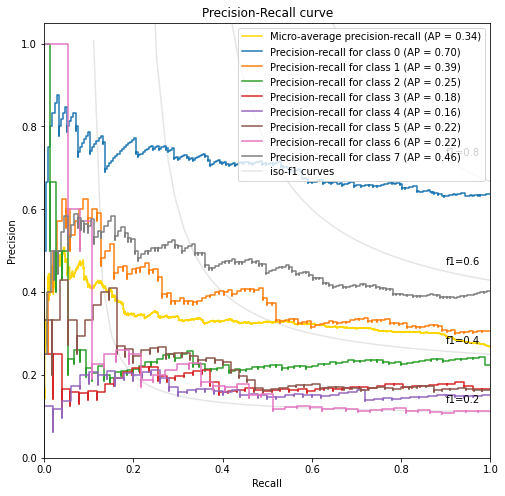

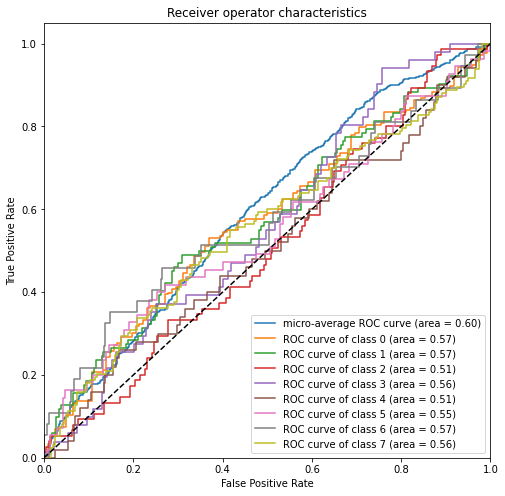

In [32]:
pr = plot_pr_curve(test_labels, predicted_labels_br.toarray())
roc = plot_roc_curve(test_labels, predicted_labels_br.toarray())
record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Binary relevance')

### Classfier Chains

In [33]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(train_features, train_labels)
# we should optimise this a little

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ClassifierChain(classifier=LogisticRegression(), require_dense=[True, True])

In [34]:
predicted_labels_cc = classifier.predict_proba(test_features)
accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_cc.toarray())

Accuracy: 0.07164179104477612
Hamming Loss: 0.28955223880597014
Brier Score: 1.692352481365838
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.69      0.65       213
           1       0.38      0.34      0.36       102
           2       0.15      0.09      0.12        75
           3       0.15      0.08      0.10        51
           4       0.17      0.10      0.12        50
           5       0.20      0.05      0.09        55
           6       0.29      0.16      0.21        37
           7       0.46      0.33      0.39       133

   micro avg       0.45      0.35      0.39       716
   macro avg       0.30      0.23      0.25       716
weighted avg       0.39      0.35      0.36       716
 samples avg       0.56      0.43      0.33       716

Confusion matrix:
 [[[ 35  87]
  [ 67 146]]

 [[175  58]
  [ 67  35]]

 [[221  39]
  [ 68   7]]

 [[261  23]
  [ 47   4]]

 [[260  25]
  [ 45   5]]

 [[268  12]
  [ 52   3]]

 

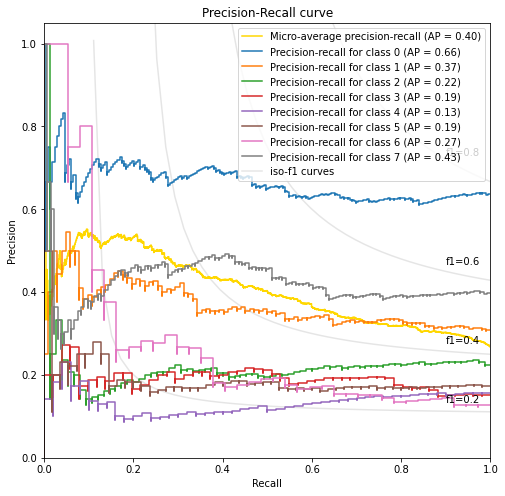

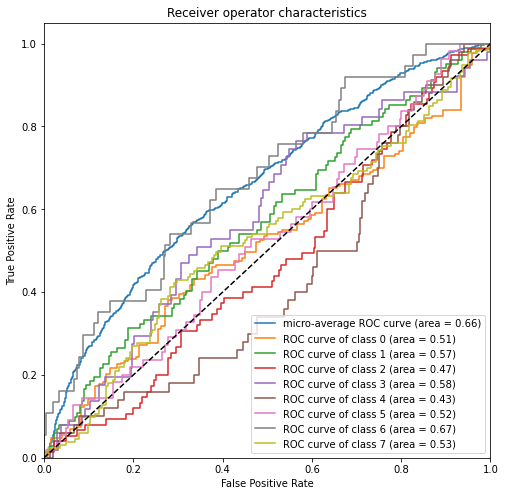

In [35]:
pr = plot_pr_curve(test_labels, predicted_labels_cc.toarray())
roc = plot_roc_curve(test_labels, predicted_labels_cc.toarray())
record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Classifier Chains')

### Label Powerset
takes correlations into account!

In [36]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(LogisticRegression())
classifier.fit(train_features, train_labels)

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LabelPowerset(classifier=LogisticRegression(), require_dense=[True, True])

In [37]:
predicted_labels_lp = classifier.predict_proba(test_features)
accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())

Accuracy: 0.1044776119402985
Hamming Loss: 0.2600746268656716
Brier Score: 1.489755778838817
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.69      0.66       213
           1       0.43      0.20      0.27       102
           2       0.12      0.03      0.04        75
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        37
           7       0.38      0.19      0.25       133

   micro avg       0.53      0.27      0.36       716
   macro avg       0.20      0.14      0.15       716
weighted avg       0.33      0.27      0.29       716
 samples avg       0.65      0.37      0.34       716

Confusion matrix:
 [[[ 39  83]
  [ 66 147]]

 [[207  26]
  [ 82  20]]

 [[245  15]
  [ 73   2]]

 [[281   3]
  [ 51   0]]

 [[281   4]
  [ 50   0]]

 [[278   2]
  [ 55   0]]

 [[

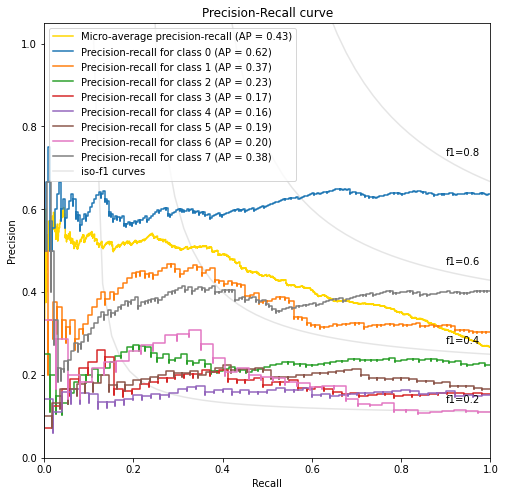

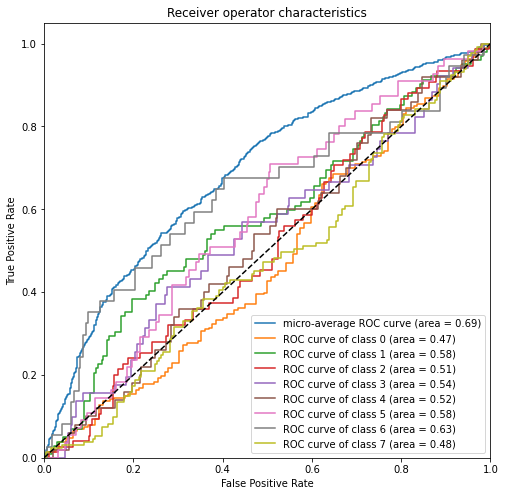

In [38]:
pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-LR')

Accuracy: 0.1373134328358209
Hamming Loss: 0.2335820895522388
Brier Score: 1.368686567164179
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.97      0.77       213
           1       1.00      0.00      0.00       102
           2       1.00      0.00      0.00        75
           3       1.00      0.00      0.00        51
           4       1.00      0.00      0.00        50
           5       1.00      0.00      0.00        55
           6       1.00      0.00      0.00        37
           7       0.55      0.05      0.08       133

   micro avg       0.63      0.30      0.40       716
   macro avg       0.90      0.13      0.11       716
weighted avg       0.81      0.30      0.24       716
 samples avg       0.65      0.42      0.39       716

Confusion matrix:
 [[[  5 117]
  [  7 206]]

 [[233   0]
  [102   0]]

 [[260   0]
  [ 75   0]]

 [[284   0]
  [ 51   0]]

 [[285   0]
  [ 50   0]]

 [[280   0]
  [ 55   0]]

 [[

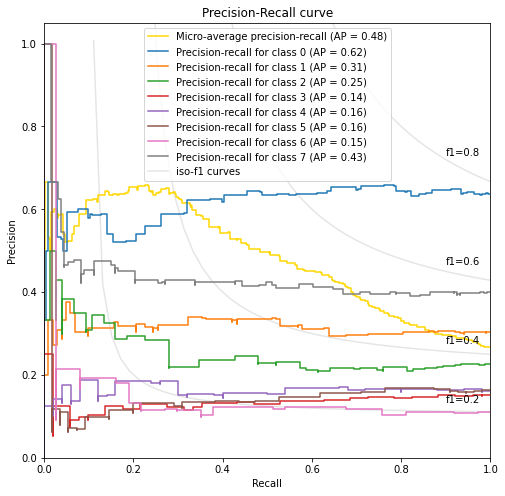

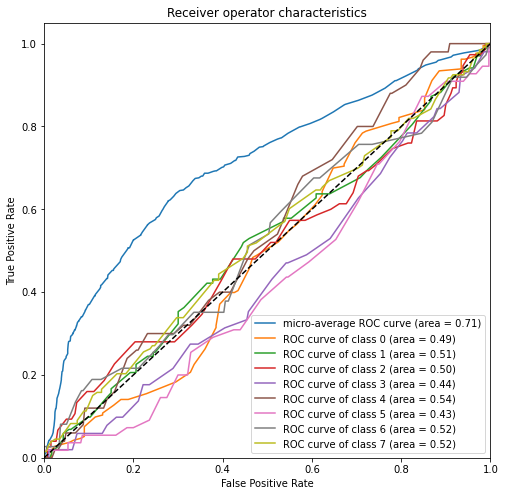

In [39]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(RandomForestClassifier())
classifier.fit(train_features, train_labels)

predicted_labels_lp = classifier.predict_proba(test_features)
accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())

pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
record_values(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Powerset-RFC')

### Visualisation

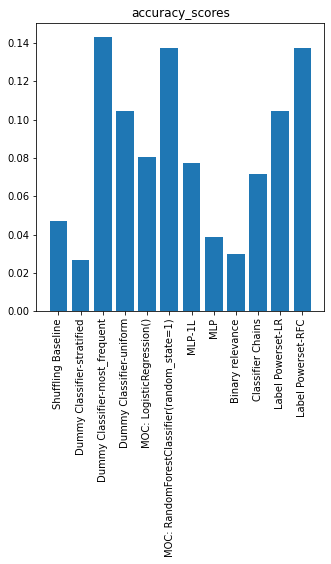

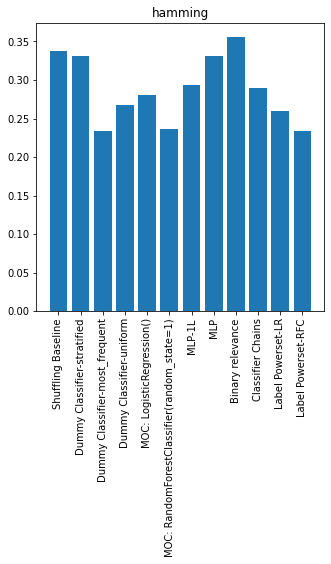

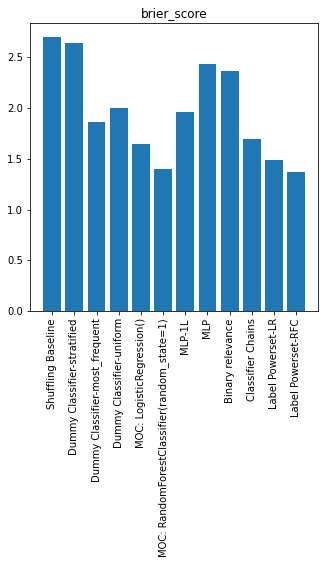

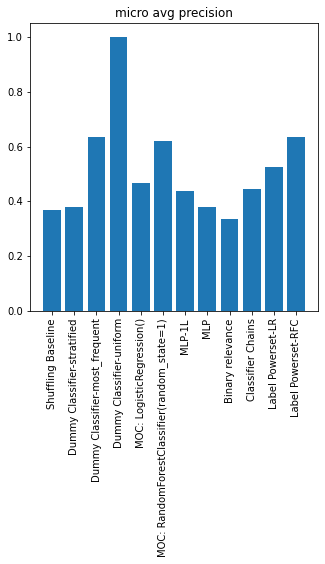

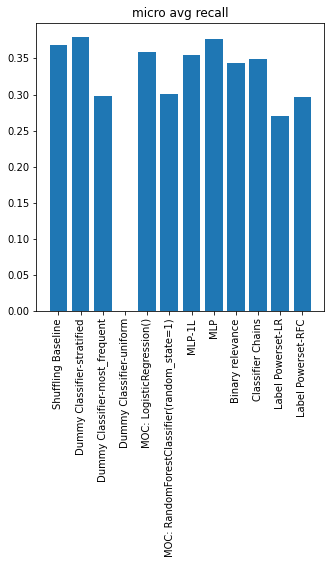

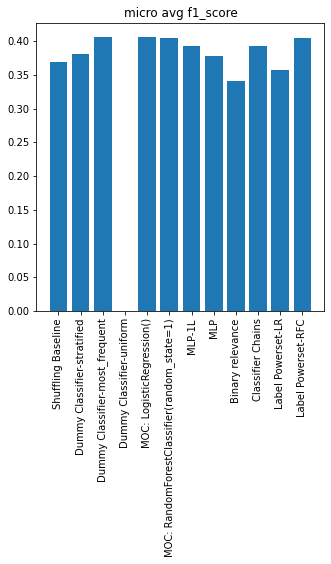

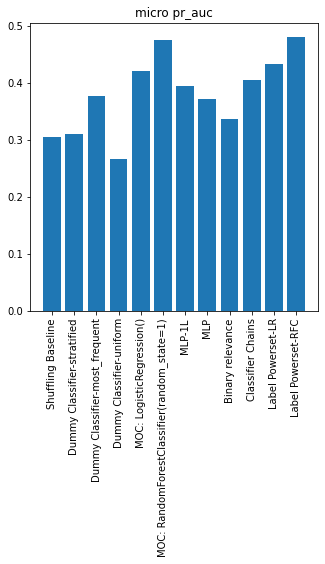

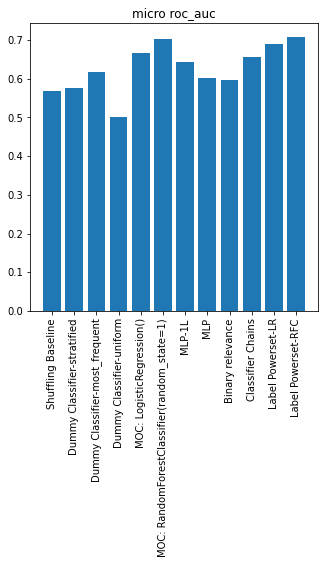

In [40]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(model_names, scores)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()
